In [1]:
# Pipeline for combining all np.sum calculations for ePix Runs 14-17
# Last ran 07/22/2025

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
runs = [14, 15, 16, 17]
file_template_general = "/sdf/group/rfar/timodo/ePix_Runs_ErrorPlot_Data/part0_run_{}.npz"
special_paths = {16: "/sdf/group/rfar/timodo/ePix_Runs_ErrorPlot_Data/part0_run_16_TEST.npz"}
file_paths = [special_paths.get(r, file_template_general.format(r)) for r in runs]
labels = [f'Run-{r}' for r in runs]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

In [4]:
def compute_errorbars_by_time(time, com):
    unique_times = np.unique(time)
    means = []
    stds = []
    for ut in unique_times:
        vals = com[time == ut]
        means.append(np.mean(vals))
        stds.append(np.std(vals))
    return unique_times, np.array(means), np.array(stds)

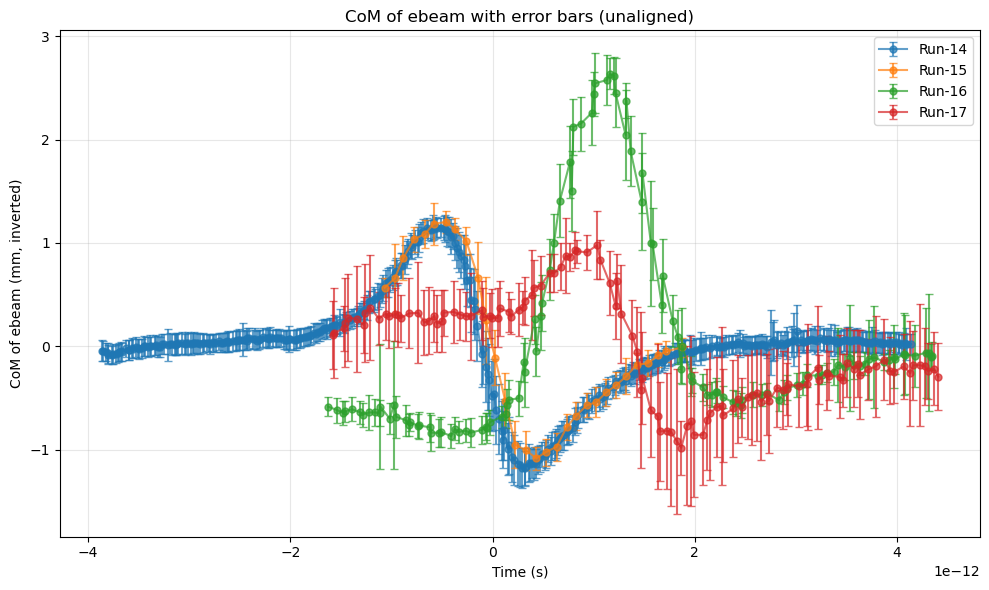

In [5]:
plt.figure(figsize=(10, 6))
for i, file_path in enumerate(file_paths):
    data = np.load(file_path)
    time = data['t_part']
    if 'img_com_2_part_100um_inverted' in data:
        com = data['img_com_2_part_100um_inverted']
    elif 'img_com_2_part_100um' in data:
        com = -data['img_com_2_part_100um']
    else:
        raise KeyError(f"No suitable CoM data in {file_path}")
    uniq_t, mean_vals, std_vals = compute_errorbars_by_time(time, com)
    plt.errorbar(uniq_t, mean_vals, yerr=std_vals, fmt='o-', capsize=3,
                 color=colors[i], label=labels[i], alpha=0.7, markersize=5)
plt.xlabel('Time (s)')
plt.ylabel('CoM of ebeam (mm, inverted)')
plt.title('CoM of ebeam with error bars (unaligned)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

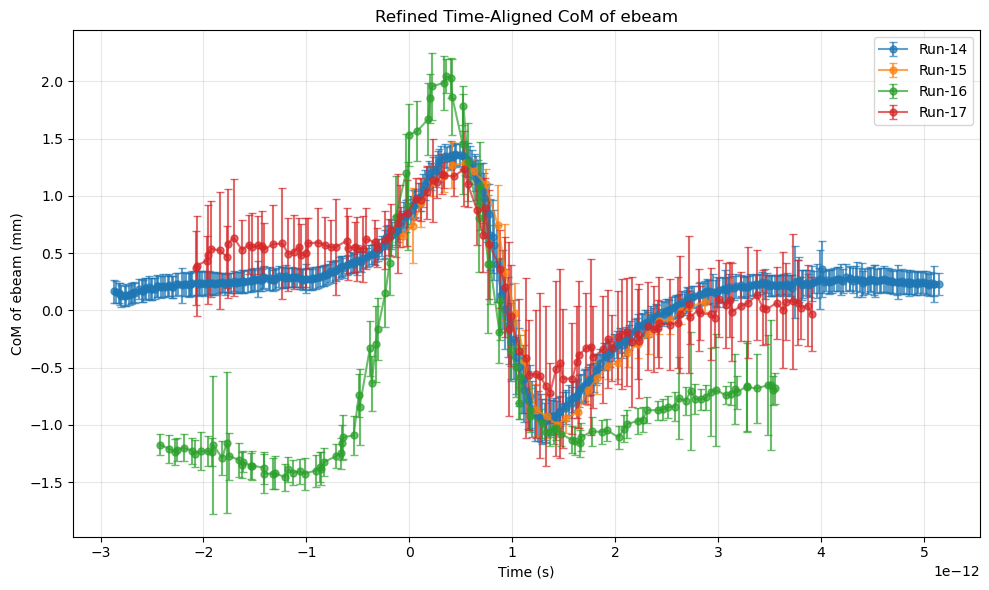

In [12]:
# Alignment parameters and reference run setup
time_shifts = {14: 1.0e-12, 15: 1.0e-12, 16: -0.8e-12, 17: -0.5e-12}
reference_runs = [22, 23, 25]
align_start, align_end = 0, 2e-12

# Compute reference means for vertical alignment
reference_means = []
for ref_run in reference_runs:
    ref_file = special_paths.get(ref_run, file_template_general.format(ref_run))
    ref_data = np.load(ref_file)
    ref_time = ref_data['t_part']
    if 'img_com_2_part_100um_inverted' in ref_data:
        ref_com = ref_data['img_com_2_part_100um_inverted']
    elif 'img_com_2_part_100um' in ref_data:
        ref_com = -ref_data['img_com_2_part_100um']
    else:
        raise KeyError(f"No suitable CoM key for reference in {ref_file}")
    mask = (ref_time >= align_start) & (ref_time <= align_end)
    reference_means.append(np.mean(ref_com[mask]))
target_mean = np.mean(reference_means)

plt.figure(figsize=(10, 6))
for i, (run, file_path) in enumerate(zip(runs, file_paths)):
    data = np.load(file_path)
    time = data['t_part']
    if 'img_com_2_part_100um_inverted' in data:
        com = data['img_com_2_part_100um_inverted']
    elif 'img_com_2_part_100um' in data:
        com = -data['img_com_2_part_100um']
    else:
        raise KeyError(f"No suitable CoM data in {file_path}")
    uniq_t, mean_vals, std_vals = compute_errorbars_by_time(time, com)
    t_shift = time_shifts.get(run, 0.0)
    shifted_t = uniq_t + t_shift
    mask = (shifted_t >= align_start) & (shifted_t <= align_end)
    current_mean = np.mean(mean_vals[mask])
    v_shift = target_mean - current_mean
    aligned_vals = mean_vals + v_shift + 0.6
    aligned_vals -= 1.0
    plt.errorbar(shifted_t, aligned_vals, yerr=std_vals, fmt='o-', capsize=3,
                 color=colors[i], label=labels[i], alpha=0.7, markersize=5)
plt.xlabel('Time (s)')
plt.ylabel('CoM of ebeam (mm)')
plt.title('Refined Time-Aligned CoM of ebeam')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()